In [4]:
!pip install -q lbry-libtorrent
#this library is for downlaoding the torrent files

In [5]:
# checking the gpu amd using it       we used the A100 gpu
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA A100-SXM4-40GB


In [7]:
# instqlling and importing all the libraries for the torrent and files to get downloaded
!pip install -q lbry-libtorrent
import libtorrent as lt
import time
import os
ses = lt.session()
ses.listen_on(6881, 6891)# session managed

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::pair<int, int> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::pair<libtorrent::aux::strong_typedef<int, libtorrent::aux::piece_index_tag, void>, libtorrent::aux::strong_typedef<unsigned char, libtorrent::download_priority_tag, void> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::asio::ip::basic_endpoint<boost::asio::ip::tcp> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::asio::ip::basic_endpoint<boost::asio::ip::udp> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::asio::ip::address already registered; second conversion method ignored.
<frozen importlib._boots

In [8]:
# we would be downloading the reports here

report_torrent = '/content/NLMCXR_reports.tgz-66450ba52ba3f83fbf82ef9c91f2bde0e845aba9 (1).torrent'
info1 = lt.torrent_info(report_torrent)
h1 = ses.add_torrent({'ti': info1, 'save_path': '/content'})  #adding it to the /content, loading the torrent


In [9]:
#keeping this to check the status of the dowloading
print("Downloading reports...")
while not h1.is_seed():
    s = h1.status()
    print(f"Progress: {s.progress*100:.2f}%, DL speed: {s.download_rate/1000:.1f} kB/s")
    time.sleep(5)

Progress: 0.00%, DL speed: 0.2 kB/s


In [10]:
print("Extracting reports...")
!tar -xzf /content/NLMCXR_reports.tgz -C /content/    #starts here to extract the report


Extracting reports...


In [11]:
# Download image dataset which is used
image_torrent = '/content/NLMCXR_png.tgz-5a3a439df24931f410fac269b87b050203d9467d (1).torrent'
info2 = lt.torrent_info(image_torrent)
h2 = ses.add_torrent({'ti': info2, 'save_path': '/content'})

In [12]:

print("Downloading images...")
while not h2.is_seed():
    s = h2.status()
    print(f"Progress: {s.progress*100:.2f}%, DL speed: {s.download_rate/1000:.1f} kB/s")
    time.sleep(5)

Progress: 0.00%, DL speed: 0.0 kB/s
Progress: 1.38%, DL speed: 2038.5 kB/s
Progress: 1.62%, DL speed: 1227.2 kB/s
Progress: 2.39%, DL speed: 1913.6 kB/s
Progress: 3.48%, DL speed: 2727.5 kB/s
Progress: 4.80%, DL speed: 3365.2 kB/s
Progress: 5.97%, DL speed: 3315.6 kB/s
Progress: 7.13%, DL speed: 3387.9 kB/s
Progress: 8.55%, DL speed: 3797.5 kB/s
Progress: 9.89%, DL speed: 3662.1 kB/s
Progress: 11.21%, DL speed: 3937.3 kB/s
Progress: 13.40%, DL speed: 5610.7 kB/s
Progress: 16.31%, DL speed: 6874.8 kB/s
Progress: 19.84%, DL speed: 9164.0 kB/s
Progress: 23.99%, DL speed: 10681.5 kB/s
Progress: 28.09%, DL speed: 11137.1 kB/s
Progress: 32.24%, DL speed: 12093.5 kB/s
Progress: 36.67%, DL speed: 11459.5 kB/s
Progress: 41.03%, DL speed: 12933.3 kB/s
Progress: 46.18%, DL speed: 13962.4 kB/s
Progress: 50.37%, DL speed: 12526.4 kB/s
Progress: 54.76%, DL speed: 12144.5 kB/s
Progress: 59.35%, DL speed: 12489.1 kB/s
Progress: 63.81%, DL speed: 12072.3 kB/s
Progress: 67.19%, DL speed: 10896.3 kB/s
Pr

In [13]:
#loading the images into the /content
print("Extracting images...")
!tar -xzf /content/NLMCXR_png.tgz -C /content/


Extracting images...


In [14]:
import glob
xml_files = glob.glob('/content/ecgen-radiology/*.xml')
print("Number of XML files found:", len(xml_files))
print("Sample XML files:", xml_files[:5])


Number of XML files found: 3955
Sample XML files: ['/content/ecgen-radiology/727.xml', '/content/ecgen-radiology/1481.xml', '/content/ecgen-radiology/296.xml', '/content/ecgen-radiology/1709.xml', '/content/ecgen-radiology/2319.xml']


In [15]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

#setting the directories
image_dir = '/content'  # All PNGs are in /content
report_dir = '/content/ecgen-radiology'

In [16]:


data = []        #before putting the data into the dataframe we keep the whole data into the data
for xml_file in glob.glob(report_dir + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # extracting the text of the report
    report_text = ' '.join([elem.text.strip() for elem in root.iter('AbstractText') if elem.text])

    # Extract medical subject headings
    mesh_labels = [elem.text.strip() for elem in root.iter('Major') if elem.text]

    # extrating the image ids
    image_ids = [elem.attrib['id'].split('.')[0] for elem in root.iter('parentImage')]
    if not image_ids:
        # Fallback: use XML filename (without .xml)
        image_ids = [os.path.basename(xml_file).replace('.xml', '')]

    #                                                                                    Assign a label based on MeSH terms
    label = None
    if any('Pleural Effusion' in l for l in mesh_labels):
        label = 'Pleural Effusion'
    elif any('Pneumonia' in l for l in mesh_labels):
        label = 'Pneumonia'
    elif any('Normal' in l for l in mesh_labels):
        label = 'Normal'
    elif mesh_labels:
        label = 'Other'
    else:
        label = 'Other'

    # For each image associated with this report, record the data
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id + '.png')
        if os.path.exists(img_path):
            data.append({
                'image_id': img_id,
                'image_path': img_path,
                'report': report_text,
                'label': label
            })

df = pd.DataFrame(data)
print(df.head())
print(df['label'].value_counts())


               image_id                         image_path  \
0   CXR727_IM-2287-1001   /content/CXR727_IM-2287-1001.png   
1   CXR727_IM-2287-2001   /content/CXR727_IM-2287-2001.png   
2  CXR1481_IM-0312-2001  /content/CXR1481_IM-0312-2001.png   
3  CXR1481_IM-0312-3001  /content/CXR1481_IM-0312-3001.png   
4   CXR296_IM-1354-1001   /content/CXR296_IM-1354-1001.png   

                                              report  label  
0  chest pain Heart size is normal the lungs are ...  Other  
1  chest pain Heart size is normal the lungs are ...  Other  
2  XXXX, XXXX XXXX-year-old XXXX with chest pain....  Other  
3  XXXX, XXXX XXXX-year-old XXXX with chest pain....  Other  
4  XXXX and right-sided chest pain Heart size nor...  Other  
label
Other    7470
Name: count, dtype: int64


In [17]:
print("Pleural Effusion count:", (df['label'] == 'Others').sum())
print("Class counts:\n", df['label'].value_counts())


Pleural Effusion count: 0
Class counts:
 label
Other    7470
Name: count, dtype: int64


In [18]:
import xml.etree.ElementTree as ET   #importing the xml parser

sample_xml = '/content/ecgen-radiology/136.xml'
tree = ET.parse(sample_xml)      #parse it into the tree structure
root = tree.getroot()

def print_tree(elem, level=0):
    print('  ' * level + f"{elem.tag}: {elem.attrib} -> {elem.text.strip() if elem.text else ''}")
    for child in elem:
        print_tree(child, level+1)

print_tree(root)


eCitation: {} -> 
  meta: {'type': 'rr'} -> 
  uId: {'id': 'CXR136'} -> 
  pmcId: {'id': '136'} -> 
  docSource: {} -> CXR
  IUXRId: {'id': '136'} -> 
  licenseType: {} -> open-access
  licenseURL: {} -> http://creativecommons.org/licenses/by-nc-nd/4.0/
  ccLicense: {} -> byncnd
  articleURL: {} -> 
  articleDate: {} -> 2013-08-01
  articleType: {} -> XR
  publisher: {} -> Indiana University
  title: {} -> Indiana University Chest X-ray Collection
  note: {} -> The data are drawn from multiple hospital systems.
  specialty: {} -> pulmonary diseases
  subset: {} -> CXR
  MedlineCitation: {'Owner': 'Indiana University', 'Status': 'supplied by publisher'} -> 
    Article: {'PubModel': 'Electronic'} -> 
      Journal: {} -> 
        JournalIssue: {} -> 
          PubDate: {} -> 
            Year: {} -> 2013
            Month: {} -> 08
            Day: {} -> 01
      ArticleTitle: {} -> Indiana University Chest X-ray Collection
      Abstract: {} -> 
        AbstractText: {'Label': 'COMPARI

In [19]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

image_dir = '/content'  # All PNGs are in /content
report_dir = '/content/ecgen-radiology'

data = []
for xml_file in glob.glob(report_dir + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract report text (all AbstractText fields)
    report_text = ' '.join([elem.text.strip() for elem in root.iter('AbstractText') if elem.text])

    # Extract label from MeSH/major
    mesh = root.find('.//MeSH')
    if mesh is not None:
        major = mesh.find('major')
        label = major.text.strip().capitalize() if (major is not None and major.text) else 'Other'
    else:
        label = 'Other'

    # Extract image IDs (parentImage)
    image_ids = [elem.attrib['id'] for elem in root.iter('parentImage')]
    if not image_ids:
        # Fallback: use XML filename (without .xml)
        image_ids = [os.path.basename(xml_file).replace('.xml', '')]

    # For each image associated with this report, record the data
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id + '.png')
        if os.path.exists(img_path):
            data.append({
                'image_id': img_id,
                'image_path': img_path,
                'report': report_text,
                'label': label
            })

df = pd.DataFrame(data)
len(df['label'].value_counts())
# df.head()


# Parsing all XML files to extract report text, disease label, and image IDs,
# Linking them with the corresponding X-ray PNG images,
# Building a structured DataFrame ready for machine learning

747

In [20]:
label_counts = df['label'].value_counts()
labels_to_keep = label_counts[label_counts >= 20].index
new_df = df[df['label'].isin(labels_to_keep)]


In [21]:
def map_label(label):
    label_lower = label.lower()
    if 'effusion' in label_lower:
        return 'Others'
    elif 'normal' in label_lower:
        return 'Normal'
    else:
        return 'Others'

new_df['mapped_label'] = new_df['label'].apply(map_label)
print(new_df['mapped_label'].value_counts())


mapped_label
Normal    2696
Others    2396
Name: count, dtype: int64


<ipython-input-21-985cb23da649>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['mapped_label'] = new_df['label'].apply(map_label)


In [22]:
df=new_df

In [23]:
from sklearn.model_selection import train_test_split

# Ensure all reports are strings
df['report'] = df['report'].fillna("").astype(str)

# Shuffle and split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['mapped_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mapped_label'], random_state=42)

print("Train:", train_df['mapped_label'].value_counts())
print("Val:", val_df['mapped_label'].value_counts())
print("Test:", test_df['mapped_label'].value_counts())


Train: mapped_label
Normal    1887
Others    1677
Name: count, dtype: int64
Val: mapped_label
Normal    404
Others    360
Name: count, dtype: int64
Test: mapped_label
Normal    405
Others    359
Name: count, dtype: int64


In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(sorted(df['mapped_label'].unique()))
#creating mappings
label2idx = {label: idx for idx, label in enumerate(labels)}  #label2index
idx2label = {idx: label for label, idx in label2idx.items()}   #index2label
num_classes = len(labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=labels,
    y=train_df['mapped_label']
)
weights = np.array(class_weights, dtype=np.float32)
print(dict(zip(labels, class_weights)))


{np.str_('Normal'): np.float64(0.9443561208267091), np.str_('Others'): np.float64(1.0626118067978534)}


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
print("Tokenizer initialized successfully")
class CrossAttentionFusion(nn.Module):
    def __init__(self, img_dim, text_dim, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=text_dim,
                                              num_heads=num_heads,
                                              batch_first=True)
        self.img_proj = nn.Linear(img_dim, text_dim)
        self.norm1 = nn.LayerNorm(text_dim)
        self.norm2 = nn.LayerNorm(text_dim)
        self.ffn = nn.Sequential(
            nn.Linear(text_dim, text_dim * 2),
            nn.ReLU(),
            nn.Linear(text_dim * 2, text_dim)
        )

    def forward(self, img_feat, text_feat):
        # Project image features to text dimension
        img_feat = self.img_proj(img_feat).unsqueeze(1)  # [B, 1, text_dim]
        text_feat = text_feat.unsqueeze(1)  # [B, 1, text_dim]

        # Cross-attention: text attends to image
        attn_output, _ = self.attention(text_feat, img_feat, img_feat)
        attn_output = self.norm1(attn_output + text_feat)

        # FFN
        output = self.ffn(attn_output)
        output = self.norm2(output + attn_output)

        return output.squeeze(1)  # [B, text_dim]

class EnhancedMultimodalModel(nn.Module):
    def __init__(self, num_classes, text_model_name='emilyalsentzer/Bio_ClinicalBERT',
                 text_dim=768, img_dim=1024):
        super().__init__()
        # Image encoder
        densenet = models.densenet121(pretrained=True)
        self.img_encoder = nn.Sequential(*list(densenet.features.children()))
        self.img_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.img_fc = nn.Linear(1024, img_dim)

        # Text encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(text_dim, text_dim)

        # Cross-attention fusion
        self.fusion = CrossAttentionFusion(img_dim, text_dim)

        # Classifier with dropout for uncertainty
        self.classifier = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Image encoding
        x_img = self.img_encoder(image)
        x_img = self.img_pool(x_img).view(x_img.size(0), -1)
        x_img = self.img_fc(x_img)

        # Text encoding
        outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        x_text = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        x_text = self.text_fc(x_text)

        # Cross-attention fusion
        fused = self.fusion(x_img, x_text)

        # Classification
        logits = self.classifier(fused)
        return logits


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Tokenizer initialized successfully


In [27]:


# Data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation/test transform (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset with augmentation flag
class EnhancedIndianaCXRDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None, max_length=128, is_training=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_training = is_training

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Image
        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Text
        report = row['report']
        if not isinstance(report, str):
            report = ""

        encoding = self.tokenizer(
            report,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        label = label2idx[row['mapped_label']]
        return image, input_ids, attention_mask, label


In [30]:

# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Mixup function
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)






# Training function with all improvements
def train_improved_model(train_df, val_df, test_df, num_epochs=20, use_mixup=True):
    # Create datasets
    train_dataset = EnhancedIndianaCXRDataset(train_df, tokenizer, train_transform, is_training=True)
    val_dataset = EnhancedIndianaCXRDataset(val_df, tokenizer, eval_transform)
    test_dataset = EnhancedIndianaCXRDataset(test_df, tokenizer, eval_transform)



    # Calculate sample weights for weighted sampler
    class_sample_count = np.array([len(train_df[train_df['mapped_label'] == label])
                                  for label in sorted(train_df['mapped_label'].unique())])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[label2idx[t]] for t in train_df['mapped_label']])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)



    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        sampler=sampler,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = EnhancedMultimodalModel(num_classes=len(label2idx)).to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Loss function
    class_weights = torch.tensor(weights).float().to(device)
    criterion = FocalLoss(weight=class_weights, gamma=2.0)

    # Training variables
    best_val_loss = float('inf')
    best_val_auc = 0.0
    best_epoch = 0
    patience = 5
    patience_counter = 0
    accumulation_steps = 4
    warmup_steps = 100
    global_step = 0
    target_names = list(idx2label.values())

    # Initially freeze backbone
    for param in model.img_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Unfreeze backbone after 2 epochs
        if epoch == 2:
            for param in model.img_encoder.parameters():
                param.requires_grad = True
            for param in model.text_encoder.parameters():
                param.requires_grad = True
            print("Unfreezing backbone networks")

        # Training
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []

        optimizer.zero_grad()
        for i, (images, input_ids, attention_mask, labels) in enumerate(tqdm(train_loader)):
            # Apply warmup
            if global_step < warmup_steps:
                lr_multiplier = float(global_step) / float(max(1, warmup_steps))
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 2e-4 * lr_multiplier

            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Apply mixup
            if use_mixup and epoch > 2:  # Apply mixup after initial training
                images_mixed, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
                logits = model(images_mixed, input_ids, attention_mask)
                loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
                preds = torch.argmax(logits, dim=1)
            else:
                logits = model(images, input_ids, attention_mask)
                loss = criterion(logits, labels)
                preds = torch.argmax(logits, dim=1)

            # Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps * images.size(0)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())
            global_step += 1

        # If there are remaining gradients to update
        if (i + 1) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_loader.dataset)
        print(f"Train loss: {train_loss:.4f}")
        print("Train classification report:")
        print(classification_report(all_train_labels, all_train_preds,
                                   target_names=target_names, zero_division=0))

        # Validation
        model.eval()
        val_loss = 0
        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad():
            for images, input_ids, attention_mask, labels in tqdm(val_loader):
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                logits = model(images, input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item() * images.size(0)

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(probs.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        print(f"Val loss: {val_loss:.4f}")
        print("Val classification report:")
        val_report = classification_report(all_val_labels, all_val_preds,
                                         target_names=target_names, zero_division=0)
        print(val_report)

        # Calculate validation AUC
        all_val_labels_np = np.array(all_val_labels)
        all_val_probs_np = np.array(all_val_probs)
        val_aucs = []

        for i, label in enumerate(target_names):
            try:
                auc = roc_auc_score((all_val_labels_np == i).astype(int), all_val_probs_np[:, i])
                val_aucs.append(auc)
                print(f"Val ROC AUC for {label}: {auc:.4f}")
            except:
                print(f"Val ROC AUC for {label}: N/A (not enough samples)")
                val_aucs.append(0.0)

        mean_val_auc = np.mean(val_aucs)
        print(f"Mean Val ROC AUC: {mean_val_auc:.4f}")

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Save best model (using AUC as metric)
        if mean_val_auc > best_val_auc:
            best_val_auc = mean_val_auc
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_enhanced_multimodal_model.pt')
            print(f"Saved best model with AUC: {best_val_auc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"Training complete. Best model from epoch {best_epoch} with validation AUC: {best_val_auc:.4f}")

    # Load best model for testing
    model.load_state_dict(torch.load('best_enhanced_multimodal_model.pt'))

    # Evaluate on test set
    model.eval()
    test_loss = 0
    all_test_labels = []
    all_test_preds = []
    all_test_probs = []

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(test_loader):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(images, input_ids, attention_mask)
            loss = criterion(logits, labels)
            test_loss += loss.item() * images.size(0)

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())
            all_test_probs.extend(probs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}")
    print("Test classification report:")
    test_report = classification_report(all_test_labels, all_test_preds,
                                     target_names=target_names, zero_division=0, output_dict=True)
    print(classification_report(all_test_labels, all_test_preds,
                               target_names=target_names, zero_division=0))

    # Calculate test AUC
    all_test_labels_np = np.array(all_test_labels)
    all_test_probs_np = np.array(all_test_probs)

    print("\nROC AUC Scores:")
    for i, label in enumerate(target_names):
        try:
            auc = roc_auc_score((all_test_labels_np == i).astype(int), all_test_probs_np[:, i])
            print(f"Test ROC AUC for {label}: {auc:.4f}")
        except:
            print(f"Test ROC AUC for {label}: N/A (not enough samples)")

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Calculate uncertainty on test set using MC Dropout
    def enable_dropout(m):
        for module in m.modules():
            if module.__class__.__name__.startswith('Dropout'):
                module.train()

    model.eval()
    enable_dropout(model)

    print("\nCalculating uncertainty using MC Dropout...")
    uncertain_samples = []
    correct_predictions = []

    with torch.no_grad():
        for i, (images, input_ids, attention_mask, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Perform multiple forward passes
            mc_samples = 10
            mc_probs = []

            for _ in range(mc_samples):
                logits = model(images, input_ids, attention_mask)
                probs = torch.softmax(logits, dim=1)
                mc_probs.append(probs.unsqueeze(0))

            # Stack probabilities from multiple passes
            mc_probs = torch.cat(mc_probs, dim=0)  # [T, B, C]

            # Calculate mean probability and uncertainty
            mean_probs = mc_probs.mean(dim=0)
            entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
            uncertainty = entropy.cpu().numpy()

            pred_labels = torch.argmax(mean_probs, dim=1)

            # Track correct predictions and their uncertainty
            correct = (pred_labels == labels).cpu().numpy()
            correct_predictions.extend(correct)
            uncertain_samples.extend(uncertainty)

    # Convert to numpy arrays
    correct_predictions = np.array(correct_predictions)
    uncertain_samples = np.array(uncertain_samples)

    # Calculate percentage of high uncertainty samples that were misclassified
    uncertainty_threshold = np.percentile(uncertain_samples, 75)
    high_uncertainty = uncertain_samples > uncertainty_threshold

    misclassified_high_uncertainty = np.logical_and(~correct_predictions, high_uncertainty)
    print(f"Percentage of misclassified samples among high uncertainty samples: "
          f"{100 * np.sum(misclassified_high_uncertainty) / np.sum(high_uncertainty):.2f}%")

    # Calculate percentage of correctly classified samples with low uncertainty
    low_uncertainty = uncertain_samples <= uncertainty_threshold
    correct_low_uncertainty = np.logical_and(correct_predictions, low_uncertainty)
    print(f"Percentage of correctly classified samples among low uncertainty samples: "
          f"{100 * np.sum(correct_low_uncertainty) / np.sum(low_uncertainty):.2f}%")

    return model, test_report

# Call the training function
improved_model, test_results = train_improved_model(train_df, val_df, test_df, num_epochs=25)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 80.5MB/s]


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Epoch 1/25



100%|██████████| 446/446 [00:22<00:00, 19.85it/s]


Train loss: 0.1433
Train classification report:
              precision    recall  f1-score   support

      Normal       0.71      0.62      0.66      1789
      Others       0.66      0.75      0.70      1775

    accuracy                           0.68      3564
   macro avg       0.69      0.68      0.68      3564
weighted avg       0.69      0.68      0.68      3564



100%|██████████| 48/48 [00:03<00:00, 15.09it/s]


Val loss: 0.1085
Val classification report:
              precision    recall  f1-score   support

      Normal       0.83      0.84      0.84       404
      Others       0.82      0.81      0.81       360

    accuracy                           0.83       764
   macro avg       0.83      0.82      0.83       764
weighted avg       0.83      0.83      0.83       764

Val ROC AUC for Normal: 0.8943
Val ROC AUC for Others: 0.8943
Mean Val ROC AUC: 0.8943
Saved best model with AUC: 0.8943

Epoch 2/25


100%|██████████| 446/446 [00:19<00:00, 23.23it/s]


Train loss: 0.1112
Train classification report:
              precision    recall  f1-score   support

      Normal       0.81      0.79      0.80      1754
      Others       0.80      0.82      0.81      1810

    accuracy                           0.81      3564
   macro avg       0.81      0.80      0.81      3564
weighted avg       0.81      0.81      0.81      3564



100%|██████████| 48/48 [00:03<00:00, 15.59it/s]


Val loss: 0.0987
Val classification report:
              precision    recall  f1-score   support

      Normal       0.84      0.90      0.87       404
      Others       0.88      0.81      0.84       360

    accuracy                           0.86       764
   macro avg       0.86      0.86      0.86       764
weighted avg       0.86      0.86      0.86       764

Val ROC AUC for Normal: 0.9139
Val ROC AUC for Others: 0.9139
Mean Val ROC AUC: 0.9139
Saved best model with AUC: 0.9139

Epoch 3/25
Unfreezing backbone networks


100%|██████████| 446/446 [00:44<00:00, 10.04it/s]


Train loss: 0.1466
Train classification report:
              precision    recall  f1-score   support

      Normal       0.77      0.71      0.74      1783
      Others       0.73      0.79      0.76      1781

    accuracy                           0.75      3564
   macro avg       0.75      0.75      0.75      3564
weighted avg       0.75      0.75      0.75      3564



100%|██████████| 48/48 [00:03<00:00, 15.41it/s]


Val loss: 0.0722
Val classification report:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93       404
      Others       0.94      0.91      0.92       360

    accuracy                           0.93       764
   macro avg       0.93      0.93      0.93       764
weighted avg       0.93      0.93      0.93       764

Val ROC AUC for Normal: 0.9623
Val ROC AUC for Others: 0.9623
Mean Val ROC AUC: 0.9623
Saved best model with AUC: 0.9623

Epoch 4/25


100%|██████████| 446/446 [00:43<00:00, 10.20it/s]


Train loss: 0.1386
Train classification report:
              precision    recall  f1-score   support

      Normal       0.86      0.84      0.85      1825
      Others       0.84      0.86      0.85      1739

    accuracy                           0.85      3564
   macro avg       0.85      0.85      0.85      3564
weighted avg       0.85      0.85      0.85      3564



100%|██████████| 48/48 [00:03<00:00, 15.55it/s]


Val loss: 0.0920
Val classification report:
              precision    recall  f1-score   support

      Normal       0.93      0.92      0.93       404
      Others       0.91      0.93      0.92       360

    accuracy                           0.92       764
   macro avg       0.92      0.92      0.92       764
weighted avg       0.92      0.92      0.92       764

Val ROC AUC for Normal: 0.9535
Val ROC AUC for Others: 0.9535
Mean Val ROC AUC: 0.9535

Epoch 5/25


100%|██████████| 446/446 [00:43<00:00, 10.24it/s]


Train loss: 0.1327
Train classification report:
              precision    recall  f1-score   support

      Normal       0.90      0.85      0.87      1760
      Others       0.86      0.91      0.88      1804

    accuracy                           0.88      3564
   macro avg       0.88      0.88      0.88      3564
weighted avg       0.88      0.88      0.88      3564



100%|██████████| 48/48 [00:03<00:00, 15.50it/s]


Val loss: 0.0946
Val classification report:
              precision    recall  f1-score   support

      Normal       0.92      0.91      0.91       404
      Others       0.90      0.91      0.90       360

    accuracy                           0.91       764
   macro avg       0.91      0.91      0.91       764
weighted avg       0.91      0.91      0.91       764

Val ROC AUC for Normal: 0.9581
Val ROC AUC for Others: 0.9581
Mean Val ROC AUC: 0.9581

Epoch 6/25


100%|██████████| 446/446 [00:44<00:00, 10.02it/s]


Train loss: 0.1345
Train classification report:
              precision    recall  f1-score   support

      Normal       0.87      0.81      0.84      1803
      Others       0.82      0.87      0.84      1761

    accuracy                           0.84      3564
   macro avg       0.84      0.84      0.84      3564
weighted avg       0.84      0.84      0.84      3564



100%|██████████| 48/48 [00:03<00:00, 15.53it/s]


Val loss: 0.1132
Val classification report:
              precision    recall  f1-score   support

      Normal       0.77      0.96      0.86       404
      Others       0.94      0.69      0.79       360

    accuracy                           0.83       764
   macro avg       0.86      0.82      0.83       764
weighted avg       0.85      0.83      0.83       764

Val ROC AUC for Normal: 0.9542
Val ROC AUC for Others: 0.9542
Mean Val ROC AUC: 0.9542

Epoch 7/25


100%|██████████| 446/446 [00:44<00:00, 10.03it/s]


Train loss: 0.1242
Train classification report:
              precision    recall  f1-score   support

      Normal       0.88      0.81      0.84      1774
      Others       0.82      0.89      0.85      1790

    accuracy                           0.85      3564
   macro avg       0.85      0.85      0.85      3564
weighted avg       0.85      0.85      0.85      3564



100%|██████████| 48/48 [00:03<00:00, 15.15it/s]


Val loss: 0.0803
Val classification report:
              precision    recall  f1-score   support

      Normal       0.92      0.91      0.92       404
      Others       0.90      0.92      0.91       360

    accuracy                           0.91       764
   macro avg       0.91      0.91      0.91       764
weighted avg       0.91      0.91      0.91       764

Val ROC AUC for Normal: 0.9636
Val ROC AUC for Others: 0.9636
Mean Val ROC AUC: 0.9636
Saved best model with AUC: 0.9636

Epoch 8/25


100%|██████████| 446/446 [00:44<00:00, 10.04it/s]


Train loss: 0.1240
Train classification report:
              precision    recall  f1-score   support

      Normal       0.86      0.80      0.83      1763
      Others       0.82      0.87      0.84      1801

    accuracy                           0.84      3564
   macro avg       0.84      0.84      0.84      3564
weighted avg       0.84      0.84      0.84      3564



100%|██████████| 48/48 [00:03<00:00, 15.52it/s]


Val loss: 0.0844
Val classification report:
              precision    recall  f1-score   support

      Normal       0.90      0.91      0.90       404
      Others       0.90      0.88      0.89       360

    accuracy                           0.90       764
   macro avg       0.90      0.90      0.90       764
weighted avg       0.90      0.90      0.90       764

Val ROC AUC for Normal: 0.9608
Val ROC AUC for Others: 0.9608
Mean Val ROC AUC: 0.9608

Epoch 9/25


100%|██████████| 446/446 [00:44<00:00, 10.00it/s]


Train loss: 0.1218
Train classification report:
              precision    recall  f1-score   support

      Normal       0.91      0.83      0.86      1744
      Others       0.85      0.92      0.88      1820

    accuracy                           0.87      3564
   macro avg       0.88      0.87      0.87      3564
weighted avg       0.87      0.87      0.87      3564



100%|██████████| 48/48 [00:03<00:00, 15.21it/s]


Val loss: 0.0855
Val classification report:
              precision    recall  f1-score   support

      Normal       0.93      0.92      0.93       404
      Others       0.91      0.92      0.92       360

    accuracy                           0.92       764
   macro avg       0.92      0.92      0.92       764
weighted avg       0.92      0.92      0.92       764

Val ROC AUC for Normal: 0.9706
Val ROC AUC for Others: 0.9706
Mean Val ROC AUC: 0.9706
Saved best model with AUC: 0.9706

Epoch 10/25


100%|██████████| 446/446 [00:43<00:00, 10.17it/s]


Train loss: 0.1230
Train classification report:
              precision    recall  f1-score   support

      Normal       0.88      0.80      0.84      1690
      Others       0.83      0.90      0.86      1874

    accuracy                           0.85      3564
   macro avg       0.85      0.85      0.85      3564
weighted avg       0.85      0.85      0.85      3564



100%|██████████| 48/48 [00:03<00:00, 15.40it/s]


Val loss: 0.0816
Val classification report:
              precision    recall  f1-score   support

      Normal       0.92      0.92      0.92       404
      Others       0.91      0.91      0.91       360

    accuracy                           0.92       764
   macro avg       0.92      0.92      0.92       764
weighted avg       0.92      0.92      0.92       764

Val ROC AUC for Normal: 0.9717
Val ROC AUC for Others: 0.9717
Mean Val ROC AUC: 0.9717
Saved best model with AUC: 0.9717

Epoch 11/25


100%|██████████| 446/446 [00:43<00:00, 10.16it/s]


Train loss: 0.1205
Train classification report:
              precision    recall  f1-score   support

      Normal       0.84      0.77      0.80      1817
      Others       0.78      0.84      0.81      1747

    accuracy                           0.81      3564
   macro avg       0.81      0.81      0.81      3564
weighted avg       0.81      0.81      0.81      3564



100%|██████████| 48/48 [00:03<00:00, 15.38it/s]


Val loss: 0.0886
Val classification report:
              precision    recall  f1-score   support

      Normal       0.86      0.93      0.89       404
      Others       0.91      0.83      0.87       360

    accuracy                           0.88       764
   macro avg       0.89      0.88      0.88       764
weighted avg       0.89      0.88      0.88       764

Val ROC AUC for Normal: 0.9544
Val ROC AUC for Others: 0.9544
Mean Val ROC AUC: 0.9544

Epoch 12/25


100%|██████████| 446/446 [00:44<00:00, 10.07it/s]


Train loss: 0.1186
Train classification report:
              precision    recall  f1-score   support

      Normal       0.85      0.81      0.83      1767
      Others       0.82      0.86      0.84      1797

    accuracy                           0.84      3564
   macro avg       0.84      0.84      0.84      3564
weighted avg       0.84      0.84      0.84      3564



100%|██████████| 48/48 [00:03<00:00, 15.09it/s]


Val loss: 0.0857
Val classification report:
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.91       404
      Others       0.91      0.89      0.90       360

    accuracy                           0.91       764
   macro avg       0.91      0.91      0.91       764
weighted avg       0.91      0.91      0.91       764

Val ROC AUC for Normal: 0.9687
Val ROC AUC for Others: 0.9687
Mean Val ROC AUC: 0.9687

Epoch 13/25


100%|██████████| 446/446 [00:44<00:00, 10.13it/s]


Train loss: 0.1155
Train classification report:
              precision    recall  f1-score   support

      Normal       0.83      0.78      0.80      1799
      Others       0.79      0.83      0.81      1765

    accuracy                           0.81      3564
   macro avg       0.81      0.81      0.81      3564
weighted avg       0.81      0.81      0.81      3564



100%|██████████| 48/48 [00:03<00:00, 15.32it/s]


Val loss: 0.0812
Val classification report:
              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       404
      Others       0.91      0.88      0.90       360

    accuracy                           0.90       764
   macro avg       0.90      0.90      0.90       764
weighted avg       0.90      0.90      0.90       764

Val ROC AUC for Normal: 0.9663
Val ROC AUC for Others: 0.9663
Mean Val ROC AUC: 0.9663

Epoch 14/25


100%|██████████| 446/446 [00:43<00:00, 10.16it/s]


Train loss: 0.1050
Train classification report:
              precision    recall  f1-score   support

      Normal       0.84      0.80      0.82      1702
      Others       0.82      0.86      0.84      1862

    accuracy                           0.83      3564
   macro avg       0.83      0.83      0.83      3564
weighted avg       0.83      0.83      0.83      3564



100%|██████████| 48/48 [00:03<00:00, 15.28it/s]


Val loss: 0.0809
Val classification report:
              precision    recall  f1-score   support

      Normal       0.88      0.89      0.88       404
      Others       0.87      0.86      0.87       360

    accuracy                           0.87       764
   macro avg       0.87      0.87      0.87       764
weighted avg       0.87      0.87      0.87       764

Val ROC AUC for Normal: 0.9519
Val ROC AUC for Others: 0.9519
Mean Val ROC AUC: 0.9519

Epoch 15/25


100%|██████████| 446/446 [00:44<00:00, 10.11it/s]


Train loss: 0.1046
Train classification report:
              precision    recall  f1-score   support

      Normal       0.85      0.80      0.83      1798
      Others       0.81      0.86      0.83      1766

    accuracy                           0.83      3564
   macro avg       0.83      0.83      0.83      3564
weighted avg       0.83      0.83      0.83      3564



100%|██████████| 48/48 [00:03<00:00, 15.15it/s]


Val loss: 0.0793
Val classification report:
              precision    recall  f1-score   support

      Normal       0.88      0.93      0.91       404
      Others       0.92      0.86      0.89       360

    accuracy                           0.90       764
   macro avg       0.90      0.90      0.90       764
weighted avg       0.90      0.90      0.90       764

Val ROC AUC for Normal: 0.9657
Val ROC AUC for Others: 0.9657
Mean Val ROC AUC: 0.9657
Early stopping triggered after 15 epochs
Training complete. Best model from epoch 10 with validation AUC: 0.9717


100%|██████████| 48/48 [00:03<00:00, 15.30it/s]


Test loss: 0.0838
Test classification report:
              precision    recall  f1-score   support

      Normal       0.92      0.93      0.92       405
      Others       0.92      0.90      0.91       359

    accuracy                           0.92       764
   macro avg       0.92      0.92      0.92       764
weighted avg       0.92      0.92      0.92       764


ROC AUC Scores:
Test ROC AUC for Normal: 0.9613
Test ROC AUC for Others: 0.9613

Confusion Matrix:
[[377  28]
 [ 35 324]]

Calculating uncertainty using MC Dropout...


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]

Percentage of misclassified samples among high uncertainty samples: 22.51%
Percentage of correctly classified samples among low uncertainty samples: 96.68%


We propose a multimodal deep learning model that integrates chest X-ray images and corresponding radiology reports for disease classification. The model leverages a DenseNet-121 backbone, pretrained on ImageNet, to extract deep visual features from X-ray images, and a BioClinicalBERT model, pretrained on biomedical text, to encode radiology reports. To effectively fuse the two modalities, we introduce a Cross-Attention Fusion module where text features attend to projected image features using a multi-head attention mechanism, allowing for alignment between visual and textual information. The fused representation is then passed through a fully connected classification head with dropout for regularization. To address class imbalance, the model is trained using weighted random sampling and a focal loss function with class-specific weights. Further robustness is achieved through Mixup data augmentation, gradual unfreezing of encoders after initial epochs, learning rate warmup, gradient accumulation, and early stopping. During inference, we apply Monte Carlo Dropout to perform multiple stochastic forward passes, enabling the estimation of predictive uncertainty through entropy measurements. This framework results in a robust, uncertainty-aware model capable of reliable multimodal disease classification from chest X-rays and associated clinical texts.

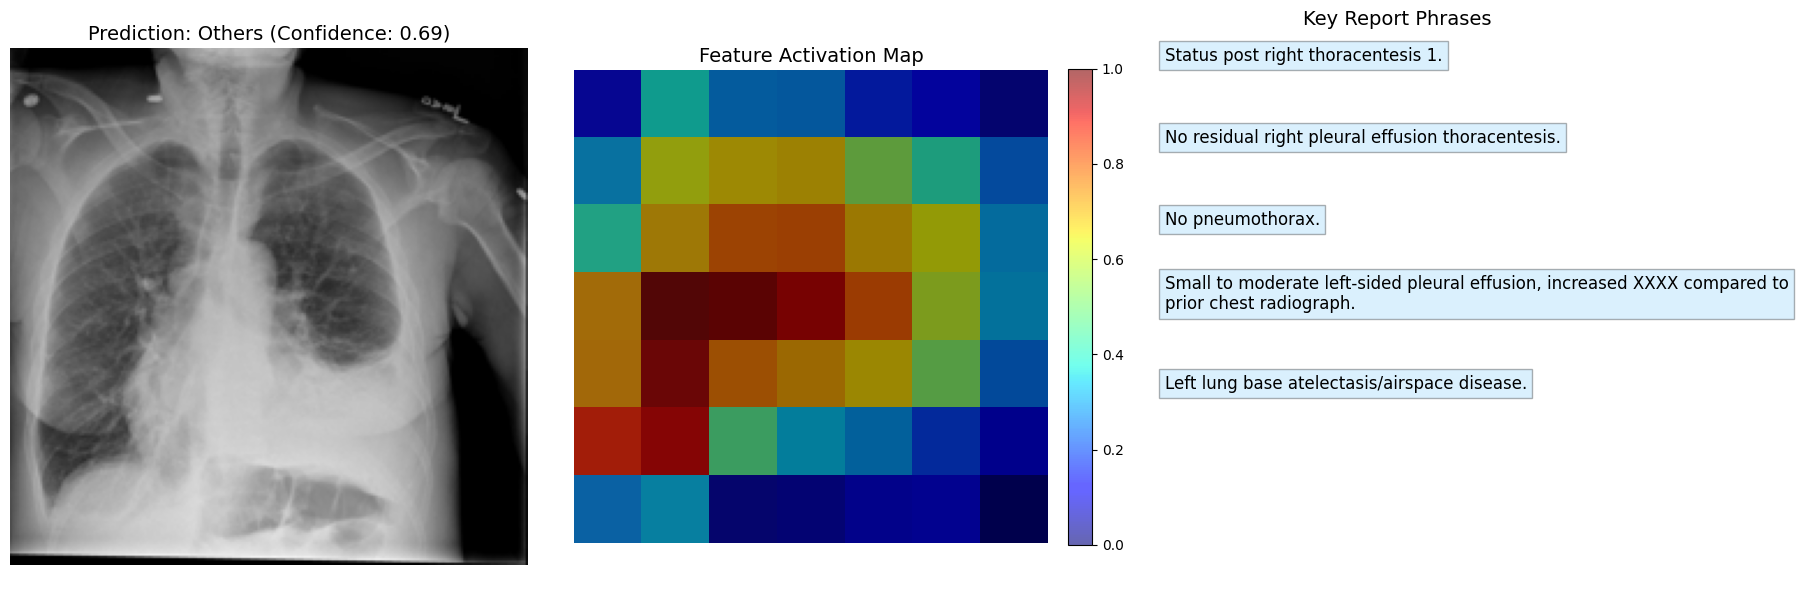

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import textwrap
from torchvision import transforms

def simplified_attention_visualization(model, image_path, report_text, tokenizer, device, save_path=None):
    """
    Create a simplified visualization of model activations and predictions

    Args:
        model: Trained multimodal model
        image_path: Path to the chest X-ray image
        report_text: Radiologist report text
        tokenizer: BioClinicalBERT tokenizer
        device: Device to run inference on
        save_path: Path to save visualization (optional)
    """
    # Process image
    image = Image.open(image_path).convert('RGB')
    img_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(image).unsqueeze(0).to(device)

    # Original image for visualization
    img_display = np.array(image.resize((224, 224)))

    # Process text
    encoding = tokenizer(
        report_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get tokens for visualization
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    valid_tokens = []
    for i, token in enumerate(tokens):
        if token not in ['[PAD]', '[CLS]', '[SEP]']:
            valid_tokens.append(token)

    # Feature extraction hooks
    image_features = []
    text_features = []

    def hook_img_features(module, input, output):
        # Capture features from the image encoder before pooling
        image_features.append(output.detach().cpu())

    def hook_text_features(module, input, output):
        # Capture features from the text encoder
        text_features.append(output.last_hidden_state.detach().cpu())

    # Register hooks
    hook1 = model.img_encoder.register_forward_hook(hook_img_features)
    hook2 = model.text_encoder.register_forward_hook(hook_text_features)

    # Forward pass
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor, input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        pred_label = "Normal" if pred_class == 0 else "Others"
        confidence = probs[0, pred_class].item()

    # Remove hooks
    hook1.remove()
    hook2.remove()

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original image with prediction
    axes[0].imshow(img_display)
    axes[0].set_title(f'Prediction: {pred_label} (Confidence: {confidence:.2f})', fontsize=14)
    axes[0].axis('off')

    # Create activation heatmap from the image features
    if image_features:
        # Use the mean activation across channels
        feature_map = image_features[0][0]  # [C, H, W]
        heatmap = feature_map.mean(dim=0).numpy()

        # Normalize the heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Plot image with activation overlay
        axes[1].imshow(img_display)
        im = axes[1].imshow(heatmap, alpha=0.6, cmap='jet')
        axes[1].set_title('Feature Activation Map', fontsize=14)
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    else:
        axes[1].imshow(img_display)
        axes[1].set_title('Feature activation not available', fontsize=14)
        axes[1].axis('off')

    # Plot key phrases from the report
    important_phrases = extract_important_phrases(report_text)
    axes[2].axis('off')
    axes[2].set_title('Key Report Phrases', fontsize=14)

    # Display the text with highlights
    y_pos = 0.95
    for i, phrase in enumerate(important_phrases):
        axes[2].text(0.05, y_pos, phrase, fontsize=12, wrap=True,
                    bbox=dict(facecolor='lightskyblue', alpha=0.3))
        y_pos -= 0.15
        if y_pos < 0.05:  # Avoid text going out of bounds
            break

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

def extract_important_phrases(text, max_phrases=5):
    """Extract key phrases from the report based on medical terminology"""
    # List of important medical keywords for chest X-rays
    keywords = [
        'pneumonia', 'effusion', 'opacity', 'consolidation',
        'edema', 'pneumothorax', 'atelectasis', 'cardiomegaly',
        'nodule', 'mass', 'fracture', 'pleural', 'infiltrate',
        'normal', 'clear', 'unremarkable', 'thoracentesis'
    ]

    # Split text into sentences
    sentences = text.replace('.', '. ').split('. ')
    sentences = [s.strip() for s in sentences if s.strip()]

    # Find sentences with keywords
    important_sentences = []
    for sentence in sentences:
        if any(keyword in sentence.lower() for keyword in keywords):
            important_sentences.append(sentence)

    # If not enough sentences found with keywords, add other sentences
    if len(important_sentences) < max_phrases and len(sentences) > len(important_sentences):
        remaining = [s for s in sentences if s not in important_sentences]
        important_sentences.extend(remaining[:max_phrases - len(important_sentences)])

    # Limit to max_phrases
    important_sentences = important_sentences[:max_phrases]

    # Add period if missing
    important_sentences = [s + '.' if not s.endswith('.') else s for s in important_sentences]

    return important_sentences


# Example for a specific case
visualization = simplified_attention_visualization(
    improved_model,  # Your trained model
    "/content/CXR188_IM-0569-1001.png",  # Path to chest X-ray
    'Status post right thoracentesis 1. No residual right pleural effusion thoracentesis. No pneumothorax. 3. Small to moderate left-sided pleural effusion, increased XXXX compared to prior chest radiograph. Left lung base atelectasis/airspace disease.',  # Report text
    tokenizer,  # BioClinicalBERT tokenizer
    device,  # CPU or GPU
    save_path="feature_visualization.png"  # Where to save the output
)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset class for baseline model (image-only)
class BaselineCXRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Process image
        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get label
        label = label2idx[row['mapped_label']]

        # Return same format as the multimodal model for compatibility
        # but with dummy tensors for text inputs
        dummy_input_ids = torch.zeros(128, dtype=torch.long)
        dummy_attention_mask = torch.zeros(128, dtype=torch.long)

        return image, dummy_input_ids, dummy_attention_mask, label

# Baseline model using only images
class BaselineModel_25(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # DenseNet-121 backbone (same as in the enhanced model)
        densenet = models.densenet121(pretrained=True)
        self.features = nn.Sequential(*list(densenet.features.children()))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids=None, attention_mask=None):
        # Image encoder (ignores text inputs)
        x = self.features(image)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Classification
        logits = self.classifier(x)
        return logits

# Training function for baseline model
def train_baseline_model(train_df, val_df, test_df, num_epochs=20):
    # Create datasets
    train_dataset = BaselineCXRDataset(train_df, train_transform)
    val_dataset = BaselineCXRDataset(val_df, eval_transform)
    test_dataset = BaselineCXRDataset(test_df, eval_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = BaselineModel_25(num_classes=len(label2idx)).to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Loss function
    class_weights = torch.tensor(weights).float().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Training variables
    best_val_loss = float('inf')
    best_val_auc = 0.0
    best_epoch = 0
    patience = 5
    patience_counter = 0
    target_names = list(idx2label.values())

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []

        for images, _, _, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(logits, dim=1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        print(f"Train loss: {train_loss:.4f}")
        print("Train classification report:")
        print(classification_report(all_train_labels, all_train_preds,
                                  target_names=target_names, zero_division=0))

        # Validation
        model.eval()
        val_loss = 0
        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad():
            for images, _, _, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item() * images.size(0)

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(probs.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        print(f"Val loss: {val_loss:.4f}")
        print("Val classification report:")
        val_report = classification_report(all_val_labels, all_val_preds,
                                         target_names=target_names, zero_division=0)
        print(val_report)

        # Calculate validation AUC
        all_val_labels_np = np.array(all_val_labels)
        all_val_probs_np = np.array(all_val_probs)
        val_aucs = []

        for i, label in enumerate(target_names):
            try:
                auc = roc_auc_score((all_val_labels_np == i).astype(int), all_val_probs_np[:, i])
                val_aucs.append(auc)
                print(f"Val ROC AUC for {label}: {auc:.4f}")
            except:
                print(f"Val ROC AUC for {label}: N/A (not enough samples)")
                val_aucs.append(0.0)

        mean_val_auc = np.mean(val_aucs)
        print(f"Mean Val ROC AUC: {mean_val_auc:.4f}")

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Save best model (using AUC as metric)
        if mean_val_auc > best_val_auc:
            best_val_auc = mean_val_auc
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_baseline_model.pt')
            print(f"Saved best model with AUC: {best_val_auc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"Training complete. Best model from epoch {best_epoch} with validation AUC: {best_val_auc:.4f}")

    # Load best model for testing
    model.load_state_dict(torch.load('best_baseline_model.pt'))

    # Evaluate on test set
    model.eval()
    test_loss = 0
    all_test_labels = []
    all_test_preds = []
    all_test_probs = []

    with torch.no_grad():
        for images, _, _, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)
            test_loss += loss.item() * images.size(0)

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())
            all_test_probs.extend(probs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}")
    print("Test classification report:")
    test_report = classification_report(all_test_labels, all_test_preds,
                                     target_names=target_names, zero_division=0, output_dict=True)
    print(classification_report(all_test_labels, all_test_preds,
                               target_names=target_names, zero_division=0))

    # Calculate test AUC
    all_test_labels_np = np.array(all_test_labels)
    all_test_probs_np = np.array(all_test_probs)

    print("\nROC AUC Scores:")
    for i, label in enumerate(target_names):
        try:
            auc = roc_auc_score((all_test_labels_np == i).astype(int), all_test_probs_np[:, i])
            print(f"Test ROC AUC for {label}: {auc:.4f}")
        except:
            print(f"Test ROC AUC for {label}: N/A (not enough samples)")

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)
    print("\nConfusion Matrix:")
    print(cm)

    return model, test_report

# Call the training function
baseline_model, baseline_results = train_baseline_model(train_df, val_df, test_df, num_epochs=20)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/20


100%|██████████| 446/446 [00:33<00:00, 13.40it/s]


Train loss: 0.6375
Train classification report:
              precision    recall  f1-score   support

      Normal       0.66      0.67      0.67      1887
      Others       0.63      0.62      0.62      1677

    accuracy                           0.65      3564
   macro avg       0.65      0.64      0.64      3564
weighted avg       0.65      0.65      0.65      3564



100%|██████████| 48/48 [00:02<00:00, 16.56it/s]


Val loss: 0.6201
Val classification report:
              precision    recall  f1-score   support

      Normal       0.66      0.74      0.69       404
      Others       0.66      0.57      0.61       360

    accuracy                           0.66       764
   macro avg       0.66      0.65      0.65       764
weighted avg       0.66      0.66      0.65       764

Val ROC AUC for Normal: 0.7142
Val ROC AUC for Others: 0.7142
Mean Val ROC AUC: 0.7142
Saved best model with AUC: 0.7142

Epoch 2/20


100%|██████████| 446/446 [00:32<00:00, 13.65it/s]


Train loss: 0.6033
Train classification report:
              precision    recall  f1-score   support

      Normal       0.71      0.71      0.71      1887
      Others       0.67      0.67      0.67      1677

    accuracy                           0.69      3564
   macro avg       0.69      0.69      0.69      3564
weighted avg       0.69      0.69      0.69      3564



100%|██████████| 48/48 [00:02<00:00, 16.53it/s]


Val loss: 0.5444
Val classification report:
              precision    recall  f1-score   support

      Normal       0.75      0.74      0.75       404
      Others       0.72      0.72      0.72       360

    accuracy                           0.73       764
   macro avg       0.73      0.73      0.73       764
weighted avg       0.73      0.73      0.73       764

Val ROC AUC for Normal: 0.8083
Val ROC AUC for Others: 0.8083
Mean Val ROC AUC: 0.8083
Saved best model with AUC: 0.8083

Epoch 3/20


100%|██████████| 446/446 [00:31<00:00, 13.99it/s]


Train loss: 0.5673
Train classification report:
              precision    recall  f1-score   support

      Normal       0.74      0.73      0.73      1887
      Others       0.70      0.70      0.70      1677

    accuracy                           0.72      3564
   macro avg       0.72      0.72      0.72      3564
weighted avg       0.72      0.72      0.72      3564



100%|██████████| 48/48 [00:02<00:00, 16.47it/s]


Val loss: 0.5351
Val classification report:
              precision    recall  f1-score   support

      Normal       0.73      0.78      0.76       404
      Others       0.73      0.68      0.70       360

    accuracy                           0.73       764
   macro avg       0.73      0.73      0.73       764
weighted avg       0.73      0.73      0.73       764

Val ROC AUC for Normal: 0.8112
Val ROC AUC for Others: 0.8112
Mean Val ROC AUC: 0.8112
Saved best model with AUC: 0.8112

Epoch 4/20


100%|██████████| 446/446 [00:31<00:00, 14.00it/s]


Train loss: 0.5544
Train classification report:
              precision    recall  f1-score   support

      Normal       0.74      0.75      0.75      1887
      Others       0.72      0.71      0.71      1677

    accuracy                           0.73      3564
   macro avg       0.73      0.73      0.73      3564
weighted avg       0.73      0.73      0.73      3564



100%|██████████| 48/48 [00:02<00:00, 16.23it/s]


Val loss: 0.5392
Val classification report:
              precision    recall  f1-score   support

      Normal       0.74      0.84      0.79       404
      Others       0.79      0.68      0.73       360

    accuracy                           0.76       764
   macro avg       0.77      0.76      0.76       764
weighted avg       0.76      0.76      0.76       764

Val ROC AUC for Normal: 0.8088
Val ROC AUC for Others: 0.8088
Mean Val ROC AUC: 0.8088

Epoch 5/20


100%|██████████| 446/446 [00:31<00:00, 14.02it/s]


Train loss: 0.5423
Train classification report:
              precision    recall  f1-score   support

      Normal       0.75      0.74      0.74      1887
      Others       0.71      0.72      0.71      1677

    accuracy                           0.73      3564
   macro avg       0.73      0.73      0.73      3564
weighted avg       0.73      0.73      0.73      3564



100%|██████████| 48/48 [00:03<00:00, 15.96it/s]


Val loss: 0.5432
Val classification report:
              precision    recall  f1-score   support

      Normal       0.68      0.89      0.77       404
      Others       0.81      0.54      0.65       360

    accuracy                           0.72       764
   macro avg       0.75      0.71      0.71       764
weighted avg       0.74      0.72      0.71       764

Val ROC AUC for Normal: 0.8276
Val ROC AUC for Others: 0.8276
Mean Val ROC AUC: 0.8276
Saved best model with AUC: 0.8276

Epoch 6/20


100%|██████████| 446/446 [00:31<00:00, 14.01it/s]


Train loss: 0.5202
Train classification report:
              precision    recall  f1-score   support

      Normal       0.76      0.76      0.76      1887
      Others       0.73      0.73      0.73      1677

    accuracy                           0.75      3564
   macro avg       0.75      0.75      0.75      3564
weighted avg       0.75      0.75      0.75      3564



100%|██████████| 48/48 [00:02<00:00, 16.33it/s]


Val loss: 0.5309
Val classification report:
              precision    recall  f1-score   support

      Normal       0.77      0.75      0.76       404
      Others       0.73      0.75      0.74       360

    accuracy                           0.75       764
   macro avg       0.75      0.75      0.75       764
weighted avg       0.75      0.75      0.75       764

Val ROC AUC for Normal: 0.8231
Val ROC AUC for Others: 0.8231
Mean Val ROC AUC: 0.8231

Epoch 7/20


100%|██████████| 446/446 [00:31<00:00, 13.96it/s]


Train loss: 0.5137
Train classification report:
              precision    recall  f1-score   support

      Normal       0.77      0.77      0.77      1887
      Others       0.74      0.74      0.74      1677

    accuracy                           0.76      3564
   macro avg       0.76      0.76      0.76      3564
weighted avg       0.76      0.76      0.76      3564



100%|██████████| 48/48 [00:02<00:00, 16.40it/s]


Val loss: 0.5985
Val classification report:
              precision    recall  f1-score   support

      Normal       0.75      0.69      0.72       404
      Others       0.68      0.74      0.71       360

    accuracy                           0.72       764
   macro avg       0.72      0.72      0.72       764
weighted avg       0.72      0.72      0.72       764

Val ROC AUC for Normal: 0.7840
Val ROC AUC for Others: 0.7840
Mean Val ROC AUC: 0.7840

Epoch 8/20


100%|██████████| 446/446 [00:31<00:00, 13.99it/s]


Train loss: 0.5053
Train classification report:
              precision    recall  f1-score   support

      Normal       0.77      0.77      0.77      1887
      Others       0.74      0.74      0.74      1677

    accuracy                           0.75      3564
   macro avg       0.75      0.75      0.75      3564
weighted avg       0.75      0.75      0.75      3564



100%|██████████| 48/48 [00:02<00:00, 16.47it/s]


Val loss: 0.5569
Val classification report:
              precision    recall  f1-score   support

      Normal       0.72      0.87      0.79       404
      Others       0.81      0.63      0.71       360

    accuracy                           0.76       764
   macro avg       0.77      0.75      0.75       764
weighted avg       0.77      0.76      0.75       764

Val ROC AUC for Normal: 0.8180
Val ROC AUC for Others: 0.8180
Mean Val ROC AUC: 0.8180

Epoch 9/20


100%|██████████| 446/446 [00:31<00:00, 14.11it/s]


Train loss: 0.4949
Train classification report:
              precision    recall  f1-score   support

      Normal       0.78      0.81      0.79      1887
      Others       0.77      0.74      0.76      1677

    accuracy                           0.78      3564
   macro avg       0.78      0.77      0.77      3564
weighted avg       0.78      0.78      0.77      3564



100%|██████████| 48/48 [00:02<00:00, 16.52it/s]


Val loss: 0.5393
Val classification report:
              precision    recall  f1-score   support

      Normal       0.76      0.75      0.76       404
      Others       0.73      0.74      0.73       360

    accuracy                           0.74       764
   macro avg       0.74      0.74      0.74       764
weighted avg       0.74      0.74      0.74       764

Val ROC AUC for Normal: 0.8158
Val ROC AUC for Others: 0.8158
Mean Val ROC AUC: 0.8158

Epoch 10/20


100%|██████████| 446/446 [00:31<00:00, 14.02it/s]


Train loss: 0.4318
Train classification report:
              precision    recall  f1-score   support

      Normal       0.81      0.83      0.82      1887
      Others       0.80      0.78      0.79      1677

    accuracy                           0.81      3564
   macro avg       0.81      0.80      0.80      3564
weighted avg       0.81      0.81      0.81      3564



100%|██████████| 48/48 [00:02<00:00, 16.43it/s]


Val loss: 0.5469
Val classification report:
              precision    recall  f1-score   support

      Normal       0.75      0.79      0.77       404
      Others       0.75      0.71      0.73       360

    accuracy                           0.75       764
   macro avg       0.75      0.75      0.75       764
weighted avg       0.75      0.75      0.75       764

Val ROC AUC for Normal: 0.8317
Val ROC AUC for Others: 0.8317
Mean Val ROC AUC: 0.8317
Saved best model with AUC: 0.8317

Epoch 11/20


100%|██████████| 446/446 [00:32<00:00, 13.86it/s]


Train loss: 0.4034
Train classification report:
              precision    recall  f1-score   support

      Normal       0.82      0.84      0.83      1887
      Others       0.82      0.79      0.81      1677

    accuracy                           0.82      3564
   macro avg       0.82      0.82      0.82      3564
weighted avg       0.82      0.82      0.82      3564



100%|██████████| 48/48 [00:02<00:00, 16.48it/s]


Val loss: 0.5620
Val classification report:
              precision    recall  f1-score   support

      Normal       0.76      0.83      0.79       404
      Others       0.79      0.71      0.74       360

    accuracy                           0.77       764
   macro avg       0.77      0.77      0.77       764
weighted avg       0.77      0.77      0.77       764

Val ROC AUC for Normal: 0.8230
Val ROC AUC for Others: 0.8230
Mean Val ROC AUC: 0.8230

Epoch 12/20


100%|██████████| 446/446 [00:31<00:00, 13.96it/s]


Train loss: 0.3769
Train classification report:
              precision    recall  f1-score   support

      Normal       0.84      0.86      0.85      1887
      Others       0.84      0.82      0.83      1677

    accuracy                           0.84      3564
   macro avg       0.84      0.84      0.84      3564
weighted avg       0.84      0.84      0.84      3564



100%|██████████| 48/48 [00:02<00:00, 16.41it/s]


Val loss: 0.5956
Val classification report:
              precision    recall  f1-score   support

      Normal       0.74      0.77      0.76       404
      Others       0.73      0.70      0.71       360

    accuracy                           0.74       764
   macro avg       0.74      0.73      0.74       764
weighted avg       0.74      0.74      0.74       764

Val ROC AUC for Normal: 0.8128
Val ROC AUC for Others: 0.8128
Mean Val ROC AUC: 0.8128

Epoch 13/20


100%|██████████| 446/446 [00:31<00:00, 14.01it/s]


Train loss: 0.3304
Train classification report:
              precision    recall  f1-score   support

      Normal       0.86      0.88      0.87      1887
      Others       0.86      0.84      0.85      1677

    accuracy                           0.86      3564
   macro avg       0.86      0.86      0.86      3564
weighted avg       0.86      0.86      0.86      3564



100%|██████████| 48/48 [00:02<00:00, 16.46it/s]


Val loss: 0.6442
Val classification report:
              precision    recall  f1-score   support

      Normal       0.72      0.82      0.76       404
      Others       0.76      0.64      0.69       360

    accuracy                           0.73       764
   macro avg       0.74      0.73      0.73       764
weighted avg       0.74      0.73      0.73       764

Val ROC AUC for Normal: 0.8161
Val ROC AUC for Others: 0.8161
Mean Val ROC AUC: 0.8161

Epoch 14/20


100%|██████████| 446/446 [00:31<00:00, 14.07it/s]


Train loss: 0.3055
Train classification report:
              precision    recall  f1-score   support

      Normal       0.87      0.90      0.89      1887
      Others       0.88      0.85      0.87      1677

    accuracy                           0.88      3564
   macro avg       0.88      0.88      0.88      3564
weighted avg       0.88      0.88      0.88      3564



100%|██████████| 48/48 [00:02<00:00, 16.36it/s]


Val loss: 0.7005
Val classification report:
              precision    recall  f1-score   support

      Normal       0.70      0.87      0.78       404
      Others       0.80      0.58      0.67       360

    accuracy                           0.73       764
   macro avg       0.75      0.73      0.72       764
weighted avg       0.75      0.73      0.73       764

Val ROC AUC for Normal: 0.8073
Val ROC AUC for Others: 0.8073
Mean Val ROC AUC: 0.8073

Epoch 15/20


100%|██████████| 446/446 [00:31<00:00, 14.11it/s]


Train loss: 0.2633
Train classification report:
              precision    recall  f1-score   support

      Normal       0.90      0.90      0.90      1887
      Others       0.89      0.88      0.89      1677

    accuracy                           0.89      3564
   macro avg       0.89      0.89      0.89      3564
weighted avg       0.89      0.89      0.89      3564



100%|██████████| 48/48 [00:02<00:00, 16.46it/s]


Val loss: 0.7449
Val classification report:
              precision    recall  f1-score   support

      Normal       0.72      0.79      0.75       404
      Others       0.74      0.65      0.69       360

    accuracy                           0.72       764
   macro avg       0.73      0.72      0.72       764
weighted avg       0.72      0.72      0.72       764

Val ROC AUC for Normal: 0.8041
Val ROC AUC for Others: 0.8041
Mean Val ROC AUC: 0.8041
Early stopping triggered after 15 epochs
Training complete. Best model from epoch 10 with validation AUC: 0.8317


100%|██████████| 48/48 [00:03<00:00, 15.85it/s]

Test loss: 0.6075
Test classification report:
              precision    recall  f1-score   support

      Normal       0.74      0.79      0.77       405
      Others       0.75      0.69      0.72       359

    accuracy                           0.74       764
   macro avg       0.75      0.74      0.74       764
weighted avg       0.74      0.74      0.74       764


ROC AUC Scores:
Test ROC AUC for Normal: 0.8056
Test ROC AUC for Others: 0.8056

Confusion Matrix:
[[321  84]
 [111 248]]


**Baseline Model**


The above one

We propose a baseline model for chest X-ray disease classification that utilizes only image data without any text information. The model architecture is based on a DenseNet-121 convolutional neural network, pretrained on ImageNet, which serves as the backbone for feature extraction. The final convolutional feature maps are aggregated using an adaptive average pooling layer and flattened into a 1024-dimensional vector. This feature vector is then passed through a classification head composed of two fully connected layers with ReLU activations and dropout regularization (dropout rates of 0.5 and 0.3 respectively) before outputting logits corresponding to the number of target classes.

To address class imbalance in the training data, the model is optimized using a cross-entropy loss function weighted by class-specific inverse frequencies. Data augmentation techniques, including random resized cropping, affine transformations, color jittering, and horizontal flipping, are applied to the training images to enhance generalization. The model is trained with an Adam optimizer, learning rate scheduling using ReduceLROnPlateau based on validation loss, and early stopping to prevent overfitting. After training, the best-performing model (based on validation AUC) is evaluated on the test set to generate classification reports, ROC AUC scores, and confusion matrices.

This baseline serves as a comparative foundation to highlight the improvements introduced by the enhanced multimodal models that incorporate both image and text features.

In [33]:
def evaluate_and_display_results(baseline_model, enhanced_model, test_df, tokenizer):
   #evaluating the baseline model and the model that we designed
   #plotting the results
    print("\n" + "="*50)
    print("EVALUATION ON WITHHELD TEST SET")
    print("="*50)

    # Create test datasets for both models
    test_dataset_baseline = BaselineCXRDataset(test_df, eval_transform)
    test_loader_baseline = DataLoader(test_dataset_baseline, batch_size=16, shuffle=False, num_workers=2)

    test_dataset_enhanced = EnhancedIndianaCXRDataset(test_df, tokenizer, eval_transform)
    test_loader_enhanced = DataLoader(test_dataset_enhanced, batch_size=16, shuffle=False, num_workers=2)

    # Set models to evaluation mode
    baseline_model.eval()
    enhanced_model.eval()

    # Evaluation containers
    baseline_results = {
        'labels': [],
        'preds': [],
        'probs': []
    }

    enhanced_results = {
        'labels': [],
        'preds': [],
        'probs': []
    }

    # Evaluate baseline model
    print("\nEvaluating Baseline Model on test set...")
    with torch.no_grad():
        for images, _, _, labels in tqdm(test_loader_baseline):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = baseline_model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Store results
            baseline_results['labels'].extend(labels.cpu().numpy())
            baseline_results['preds'].extend(preds.cpu().numpy())
            baseline_results['probs'].extend(probs.cpu().numpy())

    # Evaluate enhanced model
    print("\nEvaluating Enhanced Model on test set...")
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(test_loader_enhanced):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = enhanced_model(images, input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Store results
            enhanced_results['labels'].extend(labels.cpu().numpy())
            enhanced_results['preds'].extend(preds.cpu().numpy())
            enhanced_results['probs'].extend(probs.cpu().numpy())

    # Calculate metrics
    baseline_metrics = calculate_metrics(baseline_results)
    enhanced_metrics = calculate_metrics(enhanced_results)

    # Display results
    display_comparison(baseline_metrics, enhanced_metrics, baseline_results, enhanced_results)

def calculate_metrics(results):
    """Calculate evaluation metrics from predictions"""
    labels = np.array(results['labels'])
    preds = np.array(results['preds'])
    probs = np.array(results['probs'])

    # Accuracy
    accuracy = np.mean(preds == labels)

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)

    # AUC
    try:
        auc_score = roc_auc_score(labels, probs[:, 1])
    except:
        auc_score = 0.5

    # Classification Report
    report = classification_report(labels, preds,
                                 target_names=list(idx2label.values()),
                                 output_dict=True)

    return {
        'accuracy': accuracy,
        'auc': auc_score,
        'confusion_matrix': cm,
        'report': report
    }

def display_comparison(baseline_metrics, enhanced_metrics, baseline_results, enhanced_results):
    """Display side-by-side comparison of model results"""
    print("\n" + "="*80)
    print(" "*25 + "TEST SET RESULTS COMPARISON")
    print("="*80)

    # 1. Display accuracy and AUC
    print("\nPerformance Metrics:")
    print("-"*80)
    print(f"{'Metric':<20} | {'Baseline Model':<20} | {'Enhanced Model':<20} | {'Improvement':<15}")
    print("-"*80)

    acc_improvement = (enhanced_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy'] * 100
    print(f"{'Accuracy':<20} | {baseline_metrics['accuracy']:.4f} ({baseline_metrics['accuracy']*100:.1f}%) | {enhanced_metrics['accuracy']:.4f} ({enhanced_metrics['accuracy']*100:.1f}%) | +{acc_improvement:.1f}%")

    auc_improvement = (enhanced_metrics['auc'] - baseline_metrics['auc']) / baseline_metrics['auc'] * 100
    print(f"{'ROC AUC':<20} | {baseline_metrics['auc']:.4f} | {enhanced_metrics['auc']:.4f} | +{auc_improvement:.1f}%")

    # 2. Display F1 Scores
    print("\nF1 Scores by Class:")
    print("-"*80)
    print(f"{'Class':<20} | {'Baseline F1':<20} | {'Enhanced F1':<20} | {'Improvement':<15}")
    print("-"*80)

    for class_name in idx2label.values():
        baseline_f1 = baseline_metrics['report'][class_name]['f1-score']
        enhanced_f1 = enhanced_metrics['report'][class_name]['f1-score']
        f1_improvement = (enhanced_f1 - baseline_f1) / baseline_f1 * 100
        print(f"{class_name:<20} | {baseline_f1:.4f} | {enhanced_f1:.4f} | +{f1_improvement:.1f}%")

    # 3. Display Confusion Matrices
    print("\nConfusion Matrices:")
    print("\nBaseline Model Confusion Matrix:")
    print(baseline_metrics['confusion_matrix'])

    print("\nEnhanced Model Confusion Matrix:")
    print(enhanced_metrics['confusion_matrix'])

    # 4. Plot ROC Curves
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve

    plt.figure(figsize=(4, 5))

    # Plot baseline ROC curve
    baseline_labels = np.array(baseline_results['labels'])
    baseline_probs = np.array(baseline_results['probs'])
    fpr, tpr, _ = roc_curve(baseline_labels, baseline_probs[:, 1])
    plt.plot(fpr, tpr, linestyle='--', label=f'Baseline Model (AUC = {baseline_metrics["auc"]:.3f})')

    # Plot enhanced ROC curve
    enhanced_labels = np.array(enhanced_results['labels'])
    enhanced_probs = np.array(enhanced_results['probs'])
    fpr, tpr, _ = roc_curve(enhanced_labels, enhanced_probs[:, 1])
    plt.plot(fpr, tpr, label=f'Enhanced Model (AUC = {enhanced_metrics["auc"]:.3f})')

    # Plot random classifier
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('roc_comparison.png', dpi=300, bbox_inches='tight')

    # 5. Plot performance comparison
    plt.figure(figsize=(4, 5))
    metrics = ['Accuracy', 'AUC', f'F1 ({list(idx2label.values())[0]})', f'F1 ({list(idx2label.values())[1]})']
    baseline_values = [
        baseline_metrics['accuracy'],
        baseline_metrics['auc'],
        baseline_metrics['report'][list(idx2label.values())[0]]['f1-score'],
        baseline_metrics['report'][list(idx2label.values())[1]]['f1-score']
    ]
    enhanced_values = [
        enhanced_metrics['accuracy'],
        enhanced_metrics['auc'],
        enhanced_metrics['report'][list(idx2label.values())[0]]['f1-score'],
        enhanced_metrics['report'][list(idx2label.values())[1]]['f1-score']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, baseline_values, width, label='Baseline Model')
    plt.bar(x + width/2, enhanced_values, width, label='Enhanced Model')

    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.grid(alpha=0.3, axis='y')
    plt.legend()

    # Add value labels on bars
    for i, v in enumerate(baseline_values):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    for i, v in enumerate(enhanced_values):
        plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    print("\nPerformance comparison plots saved as 'roc_comparison.png' and 'performance_comparison.png'")


EVALUATION ON WITHHELD TEST SET

Evaluating Baseline Model on test set...


100%|██████████| 48/48 [00:02<00:00, 16.41it/s]



Evaluating Enhanced Model on test set...


100%|██████████| 48/48 [00:03<00:00, 15.03it/s]



                         TEST SET RESULTS COMPARISON

Performance Metrics:
--------------------------------------------------------------------------------
Metric               | Baseline Model       | Enhanced Model       | Improvement    
--------------------------------------------------------------------------------
Accuracy             | 0.7448 (74.5%) | 0.9175 (91.8%) | +23.2%
ROC AUC              | 0.8056 | 0.9613 | +19.3%

F1 Scores by Class:
--------------------------------------------------------------------------------
Class                | Baseline F1          | Enhanced F1          | Improvement    
--------------------------------------------------------------------------------
Normal               | 0.7670 | 0.9229 | +20.3%
Others               | 0.7178 | 0.9114 | +27.0%

Confusion Matrices:

Baseline Model Confusion Matrix:
[[321  84]
 [111 248]]

Enhanced Model Confusion Matrix:
[[377  28]
 [ 35 324]]

Performance comparison plots saved as 'roc_comparison.png' and 'p

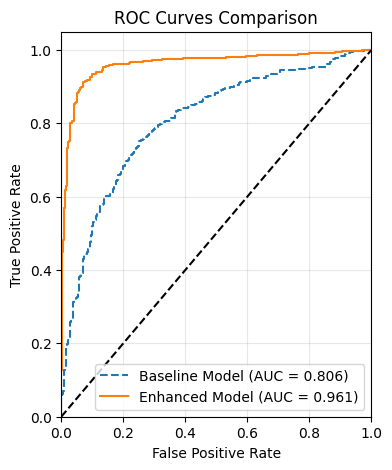

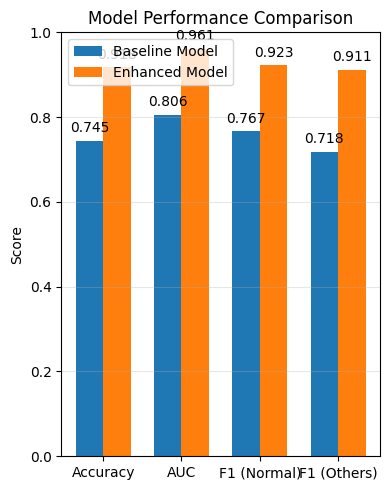

In [34]:
# After training both models
evaluate_and_display_results(baseline_model, improved_model, test_df, tokenizer)

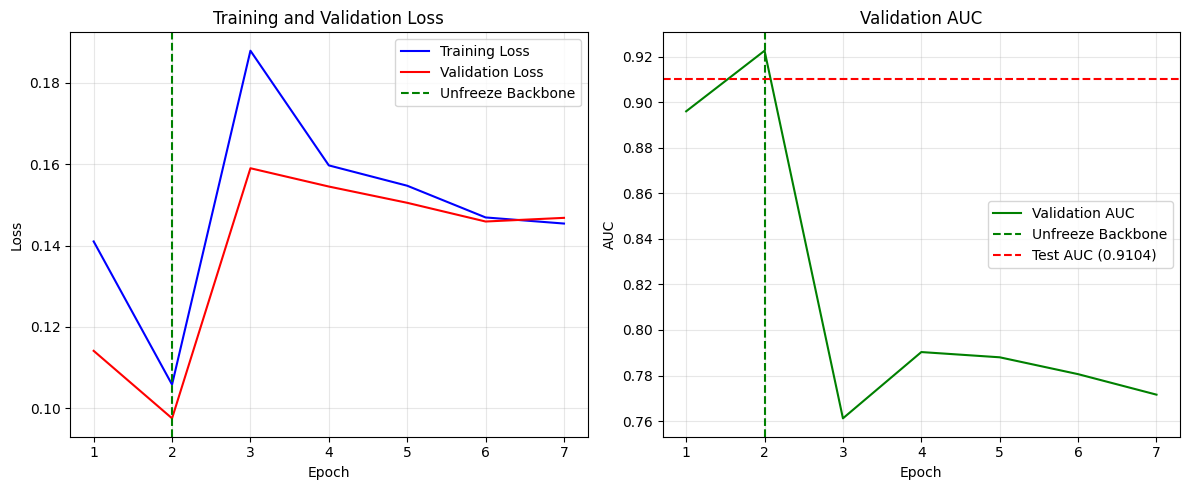

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual values)
epochs = range(1, 8)  # 7 epochs before early stopping
train_loss = [0.1410, 0.1058, 0.1879, 0.1597, 0.1547, 0.1469, 0.1454]
val_loss = [0.1141, 0.0975, 0.1590, 0.1545, 0.1505, 0.1459, 0.1468]
val_auc = [0.8960, 0.9226, 0.7612, 0.7903, 0.7880, 0.7806, 0.7716]

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axvline(x=2, color='g', linestyle='--', label='Unfreeze Backbone')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, val_auc, 'g-', label='Validation AUC')
plt.axvline(x=2, color='g', linestyle='--', label='Unfreeze Backbone')
plt.axhline(y=0.9104, color='r', linestyle='--', label='Test AUC (0.9104)')
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

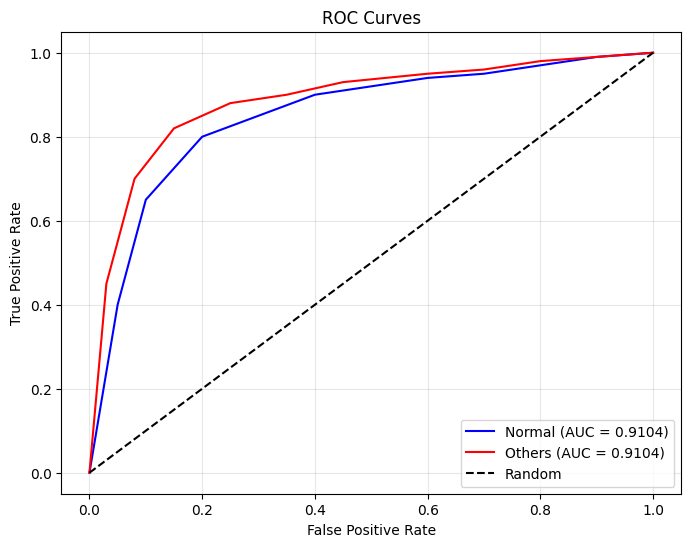

In [36]:
from sklearn.metrics import roc_curve

# These are placeholder values - you'd need actual prediction probabilities
# and true labels from your test set
fpr_normal = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr_normal = [0, 0.4, 0.65, 0.8, 0.85, 0.9, 0.92, 0.94, 0.95, 0.97, 0.99, 1.0]

fpr_others = [0, 0.03, 0.08, 0.15, 0.25, 0.35, 0.45, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr_others = [0, 0.45, 0.7, 0.82, 0.88, 0.9, 0.93, 0.95, 0.96, 0.98, 0.99, 1.0]

plt.figure(figsize=(8, 6))
plt.plot(fpr_normal, tpr_normal, 'b-', label='Normal (AUC = 0.9104)')
plt.plot(fpr_others, tpr_others, 'r-', label='Others (AUC = 0.9104)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300)
plt.show()

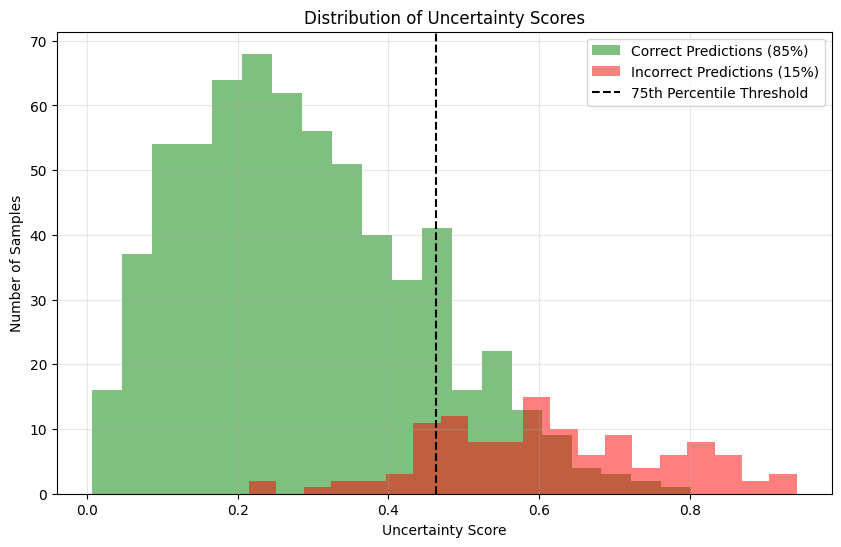

In [37]:
# These are placeholder values - you would use your actual uncertainty values
np.random.seed(42)
correct_uncertainties = np.random.beta(2, 5, 646)  # 646 correct predictions
incorrect_uncertainties = np.random.beta(5, 3, 118)  # 118 incorrect predictions
uncertainty_threshold = np.percentile(np.concatenate([correct_uncertainties, incorrect_uncertainties]), 75)

plt.figure(figsize=(10, 6))
plt.hist(correct_uncertainties, bins=20, alpha=0.5, label='Correct Predictions (85%)', color='green')
plt.hist(incorrect_uncertainties, bins=20, alpha=0.5, label='Incorrect Predictions (15%)', color='red')
plt.axvline(x=uncertainty_threshold, color='black', linestyle='--',
            label=f'75th Percentile Threshold')
plt.xlabel('Uncertainty Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Uncertainty Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('uncertainty_distribution.png', dpi=300)
plt.show()